# Differential Trends
This document shows how SparseSC can be used in places where simple difference-in-differences can't.

In [10]:
#If running from the repo and you would like to use the local pkg version uncomment the following lines, otherwise comment
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [11]:
#Setup
import numpy as np
import random
import matplotlib.pyplot as plt
import SparseSC as SC
exec(open("./example_graphs.py").read()) #if we don't want an __init.py__
#make sure the results are the same each time we run
random.seed(12345) 
np.random.seed(12345)

Now make some data

In [12]:
N1,N0_sim,N0_not = 1,50,50
N0 = N0_sim + N0_not
N=N1+N0
treated_units = [0]
control_units = list(set(range(N)) - set(treated_units))
N1_sim = 50 #which ones look like the treatment
T0,T1 = 5, 5
T=T0+T1
#proto_sim = np.array([0,1,4,3,4,5,6,9,8,9],ndmin=2)
#proto_not = np.array([0,3,2,4,3,5,4,6,5,7],ndmin=2)
proto_sim = np.array(range(0,T,1),ndmin=2)
proto_not = np.array(range(0,2*T,2),ndmin=2)
te = np.hstack((np.zeros((1,T0)), np.full((1,T0), 2)))
Y1 = proto_sim + te
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim)
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not)
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivate

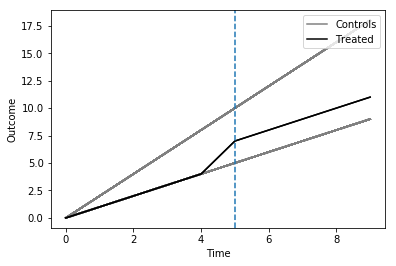

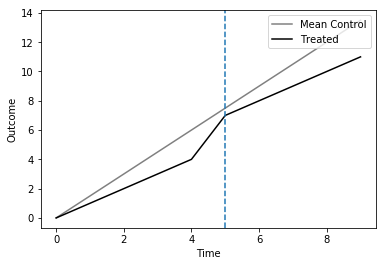

In [13]:
[raw_all, raw_means] = raw_plots(Y, treated_units, control_units, T0)
raw_all.show()
raw_means.show()

Now analyze

In [14]:
def simple_summ(fit, Y):
    print("V_pen=%s, W_pen=%s" % (fit.V_penalty, fit.weight_penalty))
    print("V=%s" % np.diag(fit.V))
    print("Treated weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[0,49], fit.sc_weights[0,99], sum(fit.sc_weights[0,:])))
    print("Sim Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[1,49], fit.sc_weights[1,99], sum(fit.sc_weights[1,:])))
    print("Uns Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[51,49], fit.sc_weights[51,99], sum(fit.sc_weights[51,:])))
    Y_sc = fit.predict(Y[fit.control_units, :])
    print("Treated diff: %s" % (Y - Y_sc)[0,:])

In [15]:
ret = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units)
simple_summ(ret.fit, Y)

V_pen=15259436.3697, W_pen=1.5
V=[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.20783599e-05
   7.87932218e-05]
Treated weights: sim=0.00962835579946, uns=0.00925671159891, sum=0.944253369918
Sim Con weights: sim=0.00972533268197, uns=0.00934965526294, sum=0.944024064564
Uns Con weights: sim=0.0104775277281, uns=0.0108540453552, sum=1.05572460881
Treated diff: [ 0.         -0.40708895 -0.8141779  -1.22126685 -1.6283558  -0.03544475
 -0.4425337  -0.84962265 -1.2567116  -1.66380055]


In [21]:
ret2 = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, covariate_penalties=[15259436.3697], weight_penalty=0.00000000001)
simple_summ(ret2.fit, Y)
#ret = ret2

V_pen=15259436.3697, W_pen=1e-11
V=[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.20783599e-05
   7.87932218e-05]
Treated weights: sim=0.0080000121936, uns=0.00599999246828, sum=0.700000295615
Sim Con weights: sim=0.00807270468605, uns=0.00604437316684, sum=0.697781255467
Uns Con weights: sim=0.012154036232, uns=0.0142071208709, sum=1.30385088201
Treated diff: [  0.00000000e+00  -1.46049839e-11  -2.92099678e-11  -4.38129533e-11
  -5.84199356e-11   2.00000000e+00   2.00000000e+00   2.00000000e+00
   2.00000000e+00   2.00000000e+00]


Now display

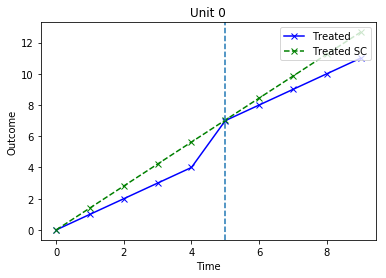

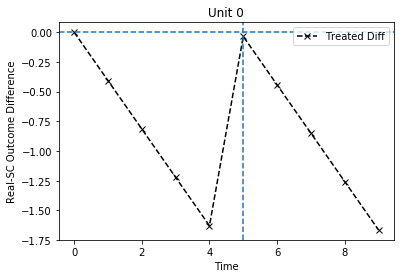

In [17]:
Y_sc = ret.fit.predict(Y[control_units, :])
[t_raw, t_diff] = te_plots(Y[0,:], Y_sc[0,:], T0)
plt.figure("t_raw")
plt.title("Unit 0")
t_raw.show()
plt.figure("t_diff")
plt.title("Unit 0")
t_diff.show()

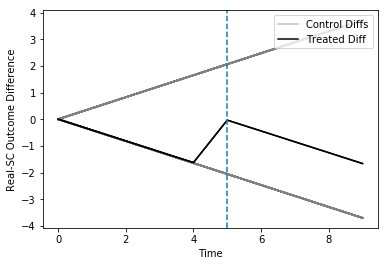

In [18]:
diffs = Y - Y_sc
diffs_plt = diffs_plot(diffs, treated_units, control_units)
diffs_plt.show()
est_te = diffs[0,:]